In [1]:
print("="*70)
print("CircuitGuard - Module 3: EfficientNet Model Training")
print("="*70)

from google.colab import drive
drive.mount('/content/drive')

CircuitGuard - Module 3: EfficientNet Model Training
Mounted at /content/drive


In [2]:
print("\n📦 Installing required libraries...")
!pip install -q torch torchvision
!pip install -q timm  # For EfficientNet
!pip install -q scikit-learn
!pip install -q seaborn

print("✅ Libraries installed successfully!\n")


import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from pathlib import Path


# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

# Timm for EfficientNet
import timm

# Sklearn for metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)



📦 Installing required libraries...
✅ Libraries installed successfully!



In [3]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")



🖥️ Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


In [4]:
# Load Project Configuration
# Project paths
PROJECT_ROOT = '/content/drive/MyDrive/CircuitGuard_Project'
DATASET_PATH = f'{PROJECT_ROOT}/training_dataset'

# Dataset splits
TRAIN_PATH = f'{DATASET_PATH}/train'
VAL_PATH = f'{DATASET_PATH}/val'
TEST_PATH = f'{DATASET_PATH}/test'

# Output paths
OUTPUT_ROOT = f'{PROJECT_ROOT}/outputs'
MODELS_PATH = f'{PROJECT_ROOT}/models'
VISUALIZATIONS_PATH = f'{OUTPUT_ROOT}/visualizations'

os.makedirs(MODELS_PATH, exist_ok=True)

# Load metadata from Module 2
metadata_path = f'{PROJECT_ROOT}/module2_metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"\n✅ Loaded metadata from Module 2")
print(f"✅ Train samples: {metadata['train_size']}")
print(f"✅ Val samples: {metadata['val_size']}")
print(f"✅ Test samples: {metadata['test_size']}")

# Get class names
class_names = sorted(os.listdir(TRAIN_PATH))
num_classes = len(class_names)
print(f"✅ Number of classes: {num_classes}")
print(f"✅ Classes: {class_names}")


✅ Loaded metadata from Module 2
✅ Train samples: 2061
✅ Val samples: 446
✅ Test samples: 446
✅ Number of classes: 6
✅ Classes: ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']


In [5]:
# Define Data Augmentation & Transforms
# Training transforms (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("✅ Data augmentation pipeline configured")
print("\n📋 Training Augmentations:")
print("  - Resize to 128×128")
print("  - Random horizontal flip (50%)")
print("  - Random vertical flip (50%)")
print("  - Random rotation (±30°)")
print("  - Color jitter (brightness, contrast, saturation)")
print("  - Normalization (ImageNet stats)")

✅ Data augmentation pipeline configured

📋 Training Augmentations:
  - Resize to 128×128
  - Random horizontal flip (50%)
  - Random vertical flip (50%)
  - Random rotation (±30°)
  - Color jitter (brightness, contrast, saturation)
  - Normalization (ImageNet stats)


In [6]:
# Create Data Loaders
# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 2

# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                       shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"\n✅ Data loaders created:")
print(f"  Train batches: {len(train_loader)} (batch size: {BATCH_SIZE})")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Verify class mapping
print(f"\n✅ Class to Index Mapping:")
for class_name, idx in train_dataset.class_to_idx.items():
    print(f"  {idx}: {class_name}")



✅ Data loaders created:
  Train batches: 65 (batch size: 32)
  Val batches: 14
  Test batches: 14

✅ Class to Index Mapping:
  0: missing_hole
  1: mouse_bite
  2: open_circuit
  3: short
  4: spur
  5: spurious_copper


In [7]:
# Build EfficientNet-B4 Model
def create_efficientnet_model(num_classes, pretrained=True):
    """
    Create EfficientNet-B4 model with custom classifier

    Args:
        num_classes: Number of output classes
        pretrained: Use ImageNet pretrained weights

    Returns:
        model: EfficientNet-B4 model
    """

    # Load pretrained EfficientNet-B4
    model = timm.create_model('efficientnet_b4', pretrained=pretrained, num_classes=num_classes)

    return model

# Create model
model = create_efficientnet_model(num_classes=num_classes, pretrained=True)
model = model.to(device)

print("✅ EfficientNet-B4 model created")
print(f"✅ Model loaded on: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Input size: 128×128×3")
print(f"  Output classes: {num_classes}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

✅ EfficientNet-B4 model created
✅ Model loaded on: cuda

📊 Model Statistics:
  Total parameters: 17,559,374
  Trainable parameters: 17,559,374
  Input size: 128×128×3
  Output classes: 6


In [9]:
# Define Loss Function and Optimizer
print("STEP 5: Setting Up Training Components")

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
LEARNING_RATE = 0.0001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"✅ Loss function: CrossEntropyLoss")
print(f"✅ Optimizer: Adam (lr={LEARNING_RATE})")
print(f"✅ LR Scheduler: ReduceLROnPlateau")

STEP 5: Setting Up Training Components
✅ Loss function: CrossEntropyLoss
✅ Optimizer: Adam (lr=0.0001)
✅ LR Scheduler: ReduceLROnPlateau


In [10]:
# Training Functions
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

print("✅ Training functions defined")


✅ Training functions defined


In [11]:
# Training Loop
print("STEP 7: Starting Model Training")
# Training hyperparameters
NUM_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 10

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Early stopping variables
best_val_acc = 0.0
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = f'{MODELS_PATH}/best_efficientnet_model.pth'

print(f"\n🚀 Training Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"  Device: {device}")

print("\n" + "="*70)
print("TRAINING STARTED")
print("="*70)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        epochs_no_improve = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)

        print(f"  ✅ New best model saved! Val Acc: {val_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"  ⏳ No improvement for {epochs_no_improve} epoch(s)")

    # Early stopping
    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        break

training_time = time.time() - start_time

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)
print(f"✅ Training time: {training_time/60:.2f} minutes")
print(f"✅ Best validation accuracy: {best_val_acc:.2f}%")
print(f"✅ Best validation loss: {best_val_loss:.4f}")
print(f"✅ Best model saved to: {best_model_path}")


STEP 7: Starting Model Training

🚀 Training Configuration:
  Epochs: 50
  Batch size: 32
  Learning rate: 0.0001
  Early stopping patience: 10
  Device: cuda

TRAINING STARTED

Epoch 1/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [02:59<00:00, 12.79s/it, loss=0.6101, acc=66.14%]



📊 Epoch 1 Summary:
  Train Loss: 1.6183 | Train Acc: 44.78%
  Val Loss:   1.2689 | Val Acc:   66.14%
  ✅ New best model saved! Val Acc: 66.14%

Epoch 2/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.88it/s, loss=0.3587, acc=76.68%]



📊 Epoch 2 Summary:
  Train Loss: 0.7874 | Train Acc: 71.03%
  Val Loss:   0.8636 | Val Acc:   76.68%
  ✅ New best model saved! Val Acc: 76.68%

Epoch 3/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.88it/s, loss=0.2987, acc=82.06%]



📊 Epoch 3 Summary:
  Train Loss: 0.5544 | Train Acc: 80.30%
  Val Loss:   0.5695 | Val Acc:   82.06%
  ✅ New best model saved! Val Acc: 82.06%

Epoch 4/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.21it/s, loss=4.1046, acc=85.20%]



📊 Epoch 4 Summary:
  Train Loss: 0.3838 | Train Acc: 86.37%
  Val Loss:   1.0796 | Val Acc:   85.20%
  ✅ New best model saved! Val Acc: 85.20%

Epoch 5/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.87it/s, loss=1.0980, acc=87.00%]



📊 Epoch 5 Summary:
  Train Loss: 0.3060 | Train Acc: 89.52%
  Val Loss:   1.2642 | Val Acc:   87.00%
  ✅ New best model saved! Val Acc: 87.00%

Epoch 6/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.19it/s, loss=0.2932, acc=88.34%]



📊 Epoch 6 Summary:
  Train Loss: 0.2283 | Train Acc: 92.67%
  Val Loss:   0.7581 | Val Acc:   88.34%
  ✅ New best model saved! Val Acc: 88.34%

Epoch 7/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.02it/s, loss=1.4383, acc=90.58%]



📊 Epoch 7 Summary:
  Train Loss: 0.1895 | Train Acc: 93.35%
  Val Loss:   0.9924 | Val Acc:   90.58%
  ✅ New best model saved! Val Acc: 90.58%

Epoch 8/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.18it/s, loss=0.0470, acc=92.60%]



📊 Epoch 8 Summary:
  Train Loss: 0.1473 | Train Acc: 94.95%
  Val Loss:   0.6783 | Val Acc:   92.60%
  ✅ New best model saved! Val Acc: 92.60%

Epoch 9/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.14it/s, loss=0.0119, acc=94.17%]



📊 Epoch 9 Summary:
  Train Loss: 0.1169 | Train Acc: 95.83%
  Val Loss:   0.2280 | Val Acc:   94.17%
  ✅ New best model saved! Val Acc: 94.17%

Epoch 10/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s, loss=2.5258, acc=94.17%]



📊 Epoch 10 Summary:
  Train Loss: 0.1230 | Train Acc: 95.68%
  Val Loss:   0.4461 | Val Acc:   94.17%
  ⏳ No improvement for 1 epoch(s)

Epoch 11/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.61it/s, loss=1.5334, acc=94.39%]



📊 Epoch 11 Summary:
  Train Loss: 0.1006 | Train Acc: 96.60%
  Val Loss:   0.5980 | Val Acc:   94.39%
  ✅ New best model saved! Val Acc: 94.39%

Epoch 12/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.72it/s, loss=0.4057, acc=94.39%]



📊 Epoch 12 Summary:
  Train Loss: 0.0952 | Train Acc: 96.75%
  Val Loss:   0.3826 | Val Acc:   94.39%
  ⏳ No improvement for 1 epoch(s)

Epoch 13/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.22it/s, loss=0.0011, acc=95.52%]



📊 Epoch 13 Summary:
  Train Loss: 0.0804 | Train Acc: 97.23%
  Val Loss:   0.2641 | Val Acc:   95.52%
  ✅ New best model saved! Val Acc: 95.52%

Epoch 14/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.20it/s, loss=0.0032, acc=95.52%]



📊 Epoch 14 Summary:
  Train Loss: 0.0626 | Train Acc: 97.87%
  Val Loss:   0.6257 | Val Acc:   95.52%
  ⏳ No improvement for 1 epoch(s)

Epoch 15/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.66it/s, loss=0.0005, acc=96.41%]



📊 Epoch 15 Summary:
  Train Loss: 0.0595 | Train Acc: 98.20%
  Val Loss:   0.3879 | Val Acc:   96.41%
  ✅ New best model saved! Val Acc: 96.41%

Epoch 16/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.99it/s, loss=0.0001, acc=96.19%]



📊 Epoch 16 Summary:
  Train Loss: 0.0634 | Train Acc: 97.57%
  Val Loss:   0.3350 | Val Acc:   96.19%
  ⏳ No improvement for 1 epoch(s)

Epoch 17/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.29it/s, loss=0.0007, acc=96.41%]



📊 Epoch 17 Summary:
  Train Loss: 0.0555 | Train Acc: 98.25%
  Val Loss:   0.6837 | Val Acc:   96.41%
  ⏳ No improvement for 2 epoch(s)

Epoch 18/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.56it/s, loss=7.2763, acc=95.07%]



📊 Epoch 18 Summary:
  Train Loss: 0.0499 | Train Acc: 98.35%
  Val Loss:   1.6490 | Val Acc:   95.07%
  ⏳ No improvement for 3 epoch(s)

Epoch 19/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.46it/s, loss=0.0015, acc=95.96%]



📊 Epoch 19 Summary:
  Train Loss: 0.0582 | Train Acc: 98.01%
  Val Loss:   0.3482 | Val Acc:   95.96%
  ⏳ No improvement for 4 epoch(s)

Epoch 20/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.75it/s, loss=0.0004, acc=96.19%]



📊 Epoch 20 Summary:
  Train Loss: 0.0399 | Train Acc: 98.74%
  Val Loss:   0.2530 | Val Acc:   96.19%
  ⏳ No improvement for 5 epoch(s)

Epoch 21/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.26it/s, loss=0.0002, acc=96.64%]



📊 Epoch 21 Summary:
  Train Loss: 0.0489 | Train Acc: 98.64%
  Val Loss:   0.2517 | Val Acc:   96.64%
  ✅ New best model saved! Val Acc: 96.64%

Epoch 22/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s, loss=0.0018, acc=96.41%]



📊 Epoch 22 Summary:
  Train Loss: 0.0491 | Train Acc: 98.20%
  Val Loss:   0.3531 | Val Acc:   96.41%
  ⏳ No improvement for 1 epoch(s)

Epoch 23/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.56it/s, loss=0.0434, acc=95.96%]



📊 Epoch 23 Summary:
  Train Loss: 0.0458 | Train Acc: 98.69%
  Val Loss:   0.8384 | Val Acc:   95.96%
  ⏳ No improvement for 2 epoch(s)

Epoch 24/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.39it/s, loss=0.0005, acc=97.31%]



📊 Epoch 24 Summary:
  Train Loss: 0.0391 | Train Acc: 98.50%
  Val Loss:   0.2030 | Val Acc:   97.31%
  ✅ New best model saved! Val Acc: 97.31%

Epoch 25/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.90it/s, loss=0.0002, acc=96.64%]



📊 Epoch 25 Summary:
  Train Loss: 0.0458 | Train Acc: 98.74%
  Val Loss:   0.5046 | Val Acc:   96.64%
  ⏳ No improvement for 1 epoch(s)

Epoch 26/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.50it/s, loss=0.0008, acc=96.41%]



📊 Epoch 26 Summary:
  Train Loss: 0.0440 | Train Acc: 98.30%
  Val Loss:   0.4168 | Val Acc:   96.41%
  ⏳ No improvement for 2 epoch(s)

Epoch 27/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.18it/s, loss=0.0002, acc=97.09%]



📊 Epoch 27 Summary:
  Train Loss: 0.0281 | Train Acc: 98.93%
  Val Loss:   0.5569 | Val Acc:   97.09%
  ⏳ No improvement for 3 epoch(s)

Epoch 28/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.33it/s, loss=1.4498, acc=95.52%]



📊 Epoch 28 Summary:
  Train Loss: 0.0330 | Train Acc: 98.88%
  Val Loss:   1.3132 | Val Acc:   95.52%
  ⏳ No improvement for 4 epoch(s)

Epoch 29/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.17it/s, loss=0.0102, acc=96.86%]



📊 Epoch 29 Summary:
  Train Loss: 0.0310 | Train Acc: 98.88%
  Val Loss:   0.1206 | Val Acc:   96.86%
  ⏳ No improvement for 5 epoch(s)

Epoch 30/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  7.25it/s, loss=0.0002, acc=96.19%]



📊 Epoch 30 Summary:
  Train Loss: 0.0293 | Train Acc: 99.08%
  Val Loss:   0.2756 | Val Acc:   96.19%
  ⏳ No improvement for 6 epoch(s)

Epoch 31/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.59it/s, loss=0.4381, acc=95.07%]



📊 Epoch 31 Summary:
  Train Loss: 0.0304 | Train Acc: 99.08%
  Val Loss:   0.4117 | Val Acc:   95.07%
  ⏳ No improvement for 7 epoch(s)

Epoch 32/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.42it/s, loss=0.0007, acc=96.19%]



📊 Epoch 32 Summary:
  Train Loss: 0.0324 | Train Acc: 98.88%
  Val Loss:   0.3044 | Val Acc:   96.19%
  ⏳ No improvement for 8 epoch(s)

Epoch 33/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.60it/s, loss=0.0001, acc=96.19%]



📊 Epoch 33 Summary:
  Train Loss: 0.0228 | Train Acc: 99.32%
  Val Loss:   0.2626 | Val Acc:   96.19%
  ⏳ No improvement for 9 epoch(s)

Epoch 34/50
----------------------------------------------------------------------


Validation: 100%|██████████| 14/14 [00:01<00:00,  8.52it/s, loss=0.0003, acc=97.09%]


📊 Epoch 34 Summary:
  Train Loss: 0.0423 | Train Acc: 98.30%
  Val Loss:   0.2733 | Val Acc:   97.09%
  ⏳ No improvement for 10 epoch(s)

⚠️ Early stopping triggered after 34 epochs

TRAINING COMPLETED
✅ Training time: 26.08 minutes
✅ Best validation accuracy: 97.31%
✅ Best validation loss: 0.2030
✅ Best model saved to: /content/drive/MyDrive/CircuitGuard_Project/models/best_efficientnet_model.pth


✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/training_history.png


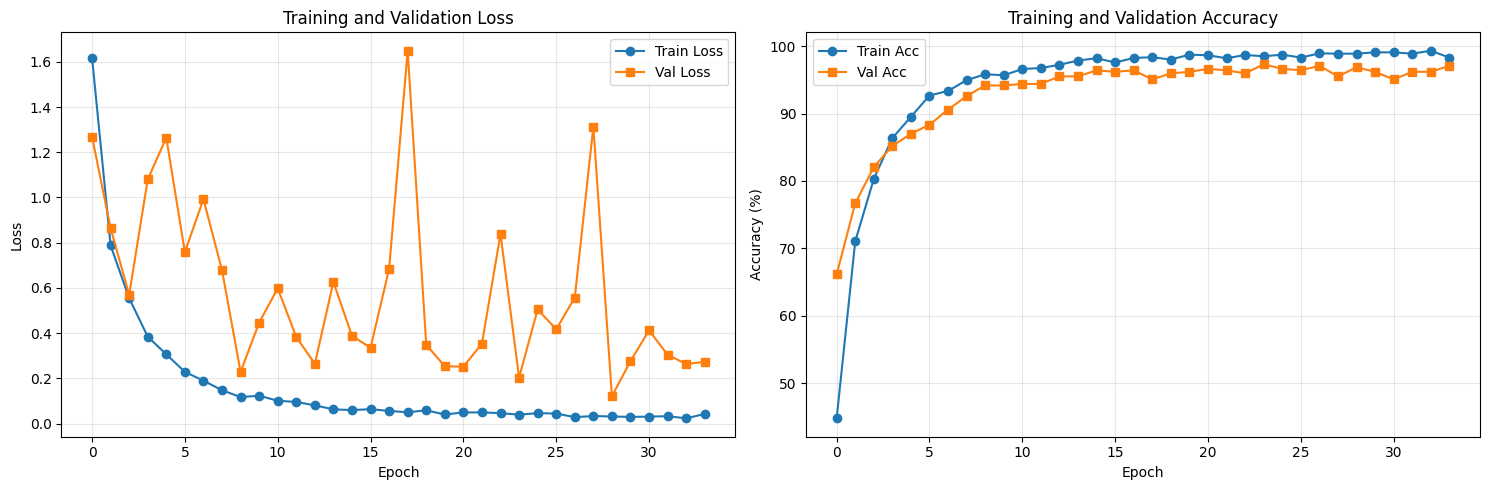

In [12]:
# Visualize Training History

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{VISUALIZATIONS_PATH}/training_history.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved: {VISUALIZATIONS_PATH}/training_history.png")
plt.show()

In [13]:
# Load Best Model and Evaluate on Test Set
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate metrics
test_accuracy = accuracy_score(all_labels, all_preds) * 100
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")

# Check if target accuracy achieved
if test_accuracy >= 97.0:
    print(f"\n🎉 TARGET ACHIEVED! Test accuracy ≥ 97%")
else:
    print(f"\n⚠️ Target not met. Need {97.0 - test_accuracy:.2f}% more accuracy")


✅ Loaded best model from epoch 24


Testing: 100%|██████████| 14/14 [02:58<00:00, 12.79s/it]


TEST SET RESULTS

✅ Test Accuracy: 97.76%
✅ Precision: 0.9776
✅ Recall: 0.9776
✅ F1-Score: 0.9775

🎉 TARGET ACHIEVED! Test accuracy ≥ 97%


✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/confusion_matrix.png


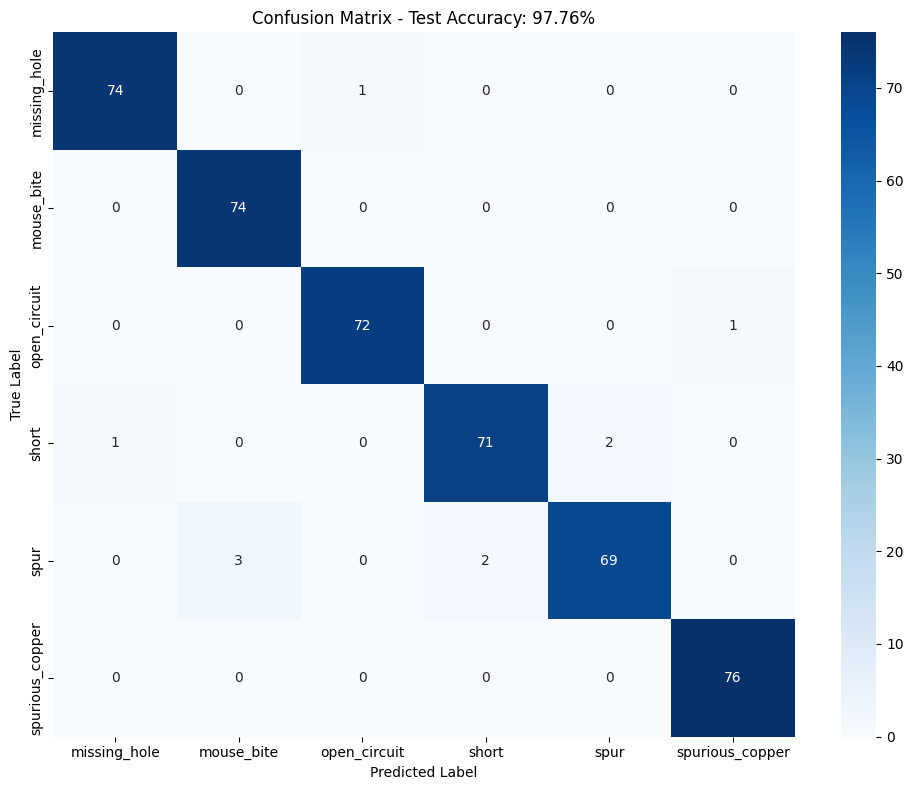

In [14]:
# Confusion Matrix
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - Test Accuracy: {test_accuracy:.2f}%')
plt.tight_layout()
plt.savefig(f'{VISUALIZATIONS_PATH}/confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved: {VISUALIZATIONS_PATH}/confusion_matrix.png")
plt.show()

In [15]:
# Classification Report

# Generate classification report
report = classification_report(all_labels, all_preds,
                               target_names=class_names,
                               digits=4)

print("\n📊 Classification Report:")
print(report)

# Save report to file
report_path = f'{MODELS_PATH}/classification_report.txt'
with open(report_path, 'w') as f:
    f.write("CircuitGuard - EfficientNet-B4 Classification Report\n")
    f.write("="*70 + "\n\n")
    f.write(f"Test Accuracy: {test_accuracy:.2f}%\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n\n")
    f.write(report)

print(f"✅ Report saved to: {report_path}")



📊 Classification Report:
                 precision    recall  f1-score   support

   missing_hole     0.9867    0.9867    0.9867        75
     mouse_bite     0.9610    1.0000    0.9801        74
   open_circuit     0.9863    0.9863    0.9863        73
          short     0.9726    0.9595    0.9660        74
           spur     0.9718    0.9324    0.9517        74
spurious_copper     0.9870    1.0000    0.9935        76

       accuracy                         0.9776       446
      macro avg     0.9776    0.9775    0.9774       446
   weighted avg     0.9776    0.9776    0.9775       446

✅ Report saved to: /content/drive/MyDrive/CircuitGuard_Project/models/classification_report.txt


In [16]:
# Save Training Metadata
module3_metadata = {
    'module': 'Module_3_Model_Training',
    'model': 'EfficientNet-B4',
    'training_config': {
        'epochs_trained': len(history['train_loss']),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'Adam',
        'loss_function': 'CrossEntropyLoss'
    },
    'dataset': {
        'num_classes': num_classes,
        'class_names': class_names,
        'train_samples': metadata['train_size'],
        'val_samples': metadata['val_size'],
        'test_samples': metadata['test_size']
    },
    'results': {
        'best_val_accuracy': float(best_val_acc),
        'best_val_loss': float(best_val_loss),
        'test_accuracy': float(test_accuracy),
        'test_precision': float(precision),
        'test_recall': float(recall),
        'test_f1': float(f1)
    },
    'training_history': history,
    'model_path': best_model_path,
    'training_time_minutes': training_time/60
}

module3_metadata_path = f'{PROJECT_ROOT}/module3_metadata.json'
with open(module3_metadata_path, 'w') as f:
    json.dump(module3_metadata, f, indent=4)

print(f"✅ Training metadata saved to: {module3_metadata_path}")


✅ Training metadata saved to: /content/drive/MyDrive/CircuitGuard_Project/module3_metadata.json


In [17]:
#  Summary
print(f"  ✅ Model: EfficientNet-B4")
print(f"  ✅ Training samples: {metadata['train_size']}")
print(f"  ✅ Validation samples: {metadata['val_size']}")
print(f"  ✅ Test samples: {metadata['test_size']}")
print(f"  ✅ Epochs trained: {len(history['train_loss'])}")
print(f"  ✅ Training time: {training_time/60:.2f} minutes")
print(f"  ✅ Best validation accuracy: {best_val_acc:.2f}%")
print(f"  ✅ Test accuracy: {test_accuracy:.2f}%")
print(f"  ✅ Test F1-score: {f1:.4f}")

if test_accuracy >= 97.0:
    print(f"\n🎉 SUCCESS! Achieved target accuracy of ≥97%")
else:
    print(f"\n📝 Note: Target is 97% accuracy. Current: {test_accuracy:.2f}%")

print(f"\n📁 Model saved to: {best_model_path}")
print(f"📁 Visualizations: {VISUALIZATIONS_PATH}")



  ✅ Model: EfficientNet-B4
  ✅ Training samples: 2061
  ✅ Validation samples: 446
  ✅ Test samples: 446
  ✅ Epochs trained: 34
  ✅ Training time: 26.08 minutes
  ✅ Best validation accuracy: 97.31%
  ✅ Test accuracy: 97.76%
  ✅ Test F1-score: 0.9775

🎉 SUCCESS! Achieved target accuracy of ≥97%

📁 Model saved to: /content/drive/MyDrive/CircuitGuard_Project/models/best_efficientnet_model.pth
📁 Visualizations: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations
